<a href="https://colab.research.google.com/github/Rex60309/Generative_AI/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI 家教**

## **結果展示**

* 使用範例1. **程式設計** 方面

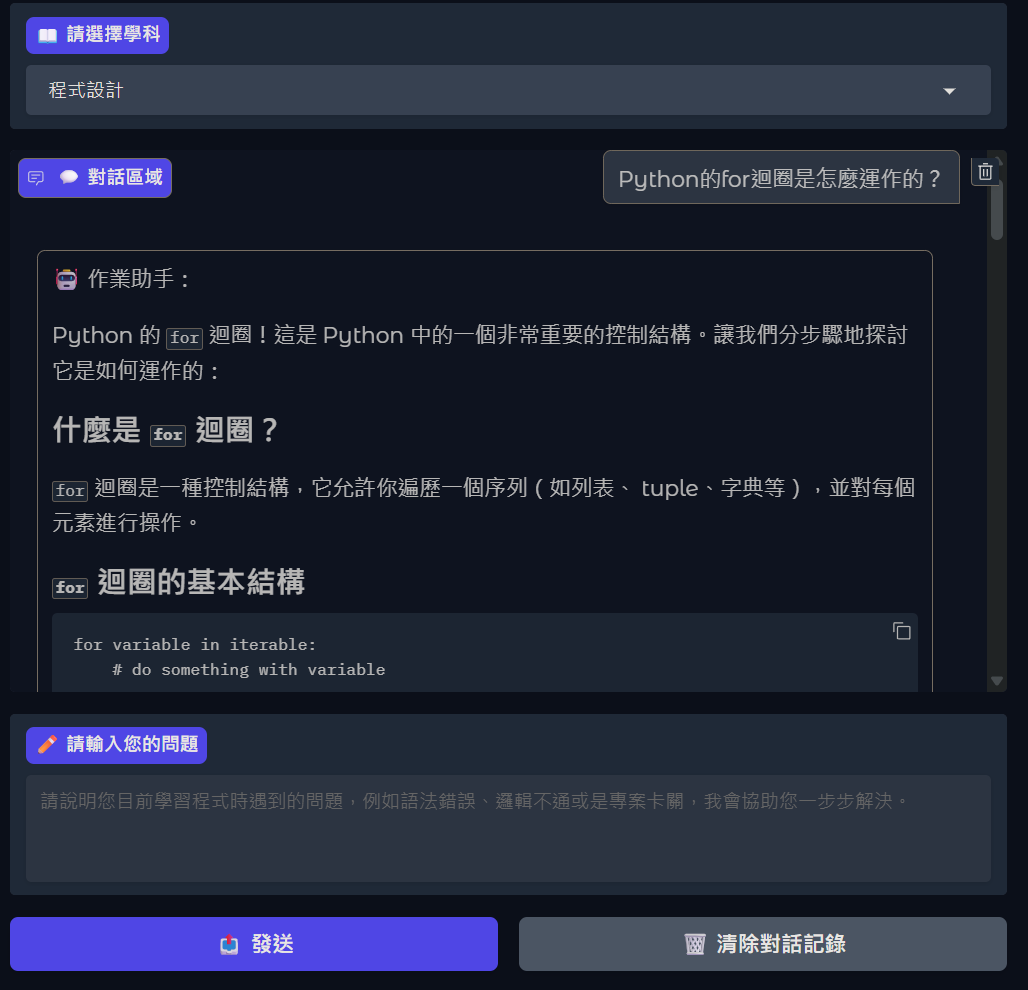

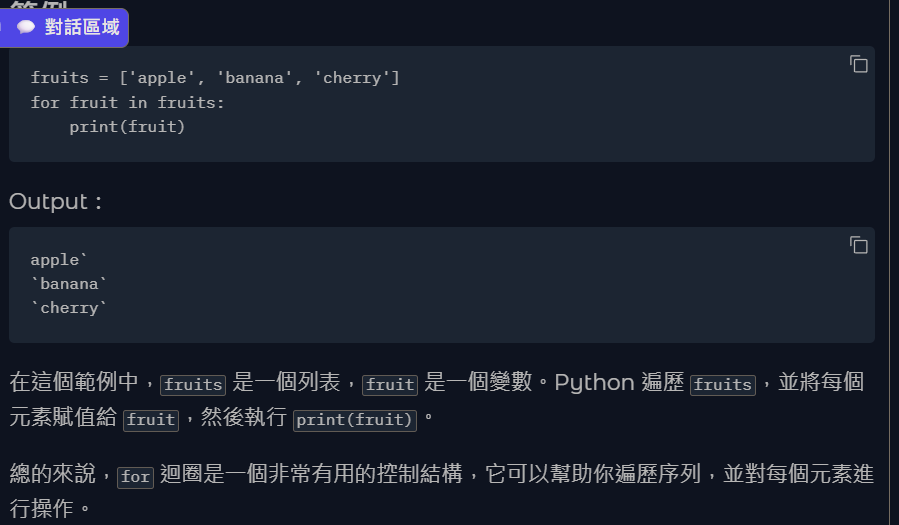

* 繼續追問下去

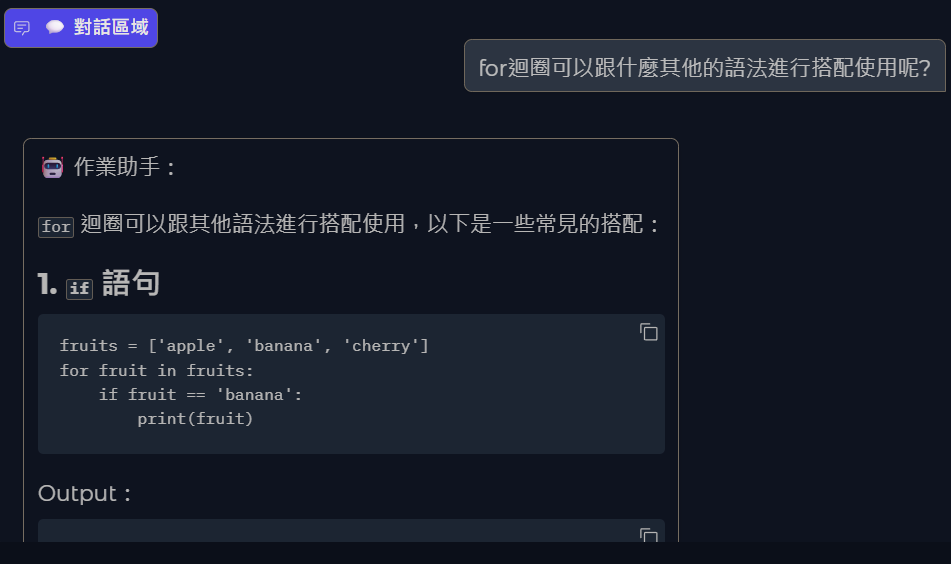

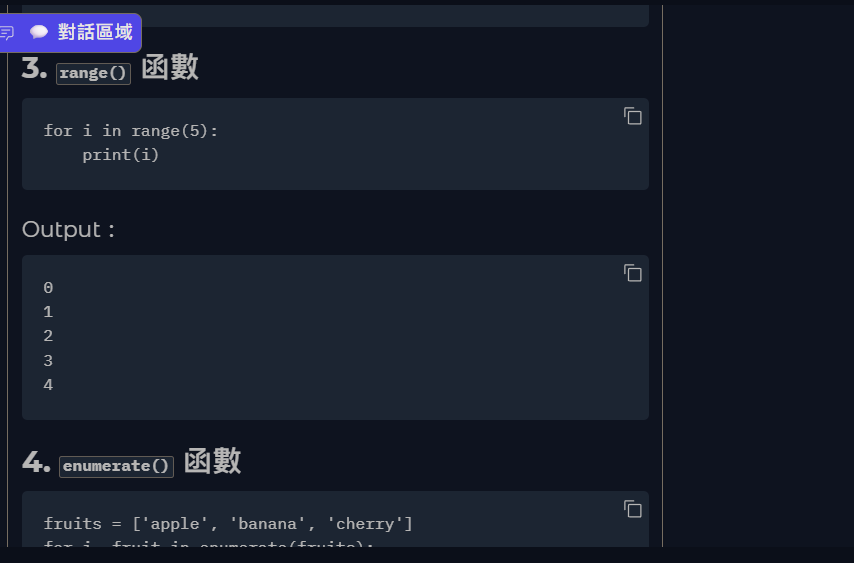

* 使用範例2. **數學** 方面

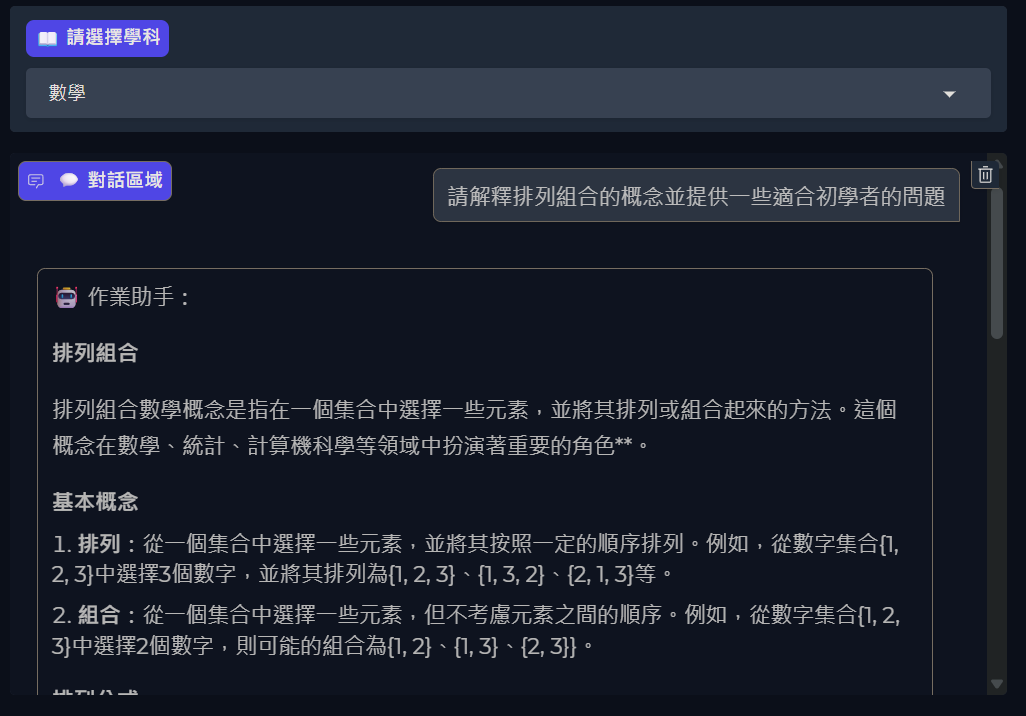

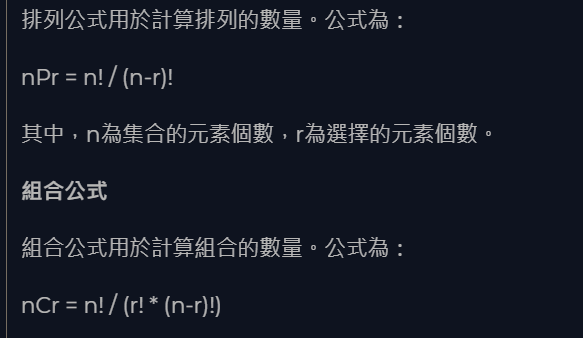

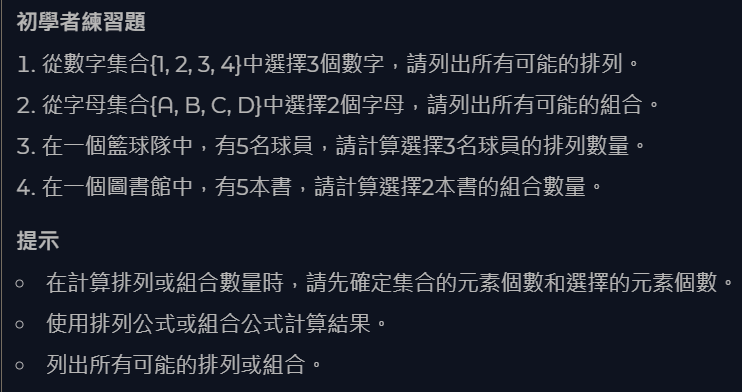

* 還會適度地提出額外的學習資源平台
* 以鼓勵的口吻幫提問者加油打氣給與其動力

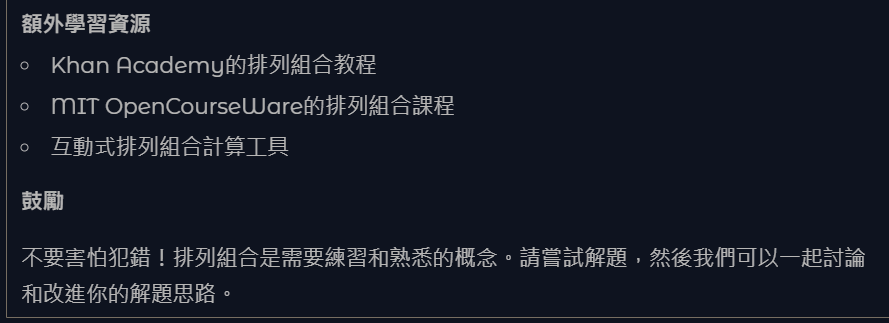

* 若對於以上給的問題不知道答案怎麼辦?

    - 可以請 **AI 家教** 給你完整的詳解！

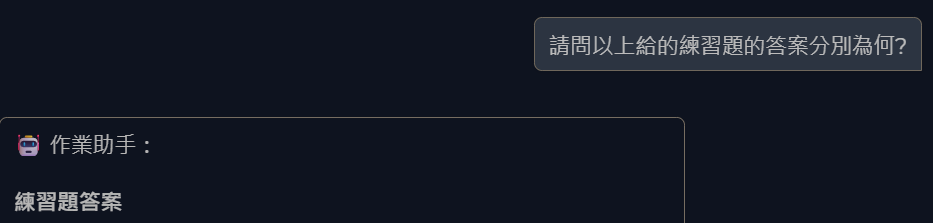

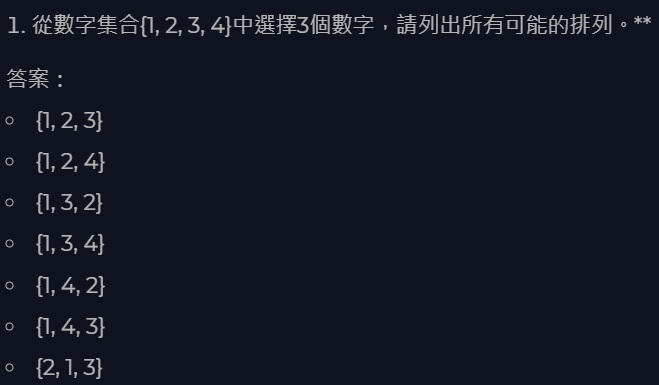

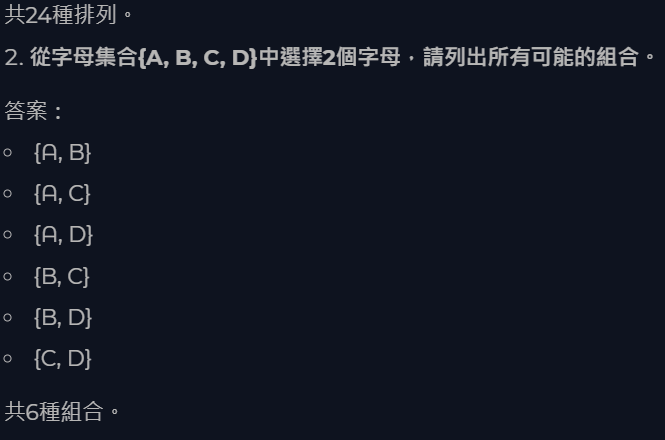

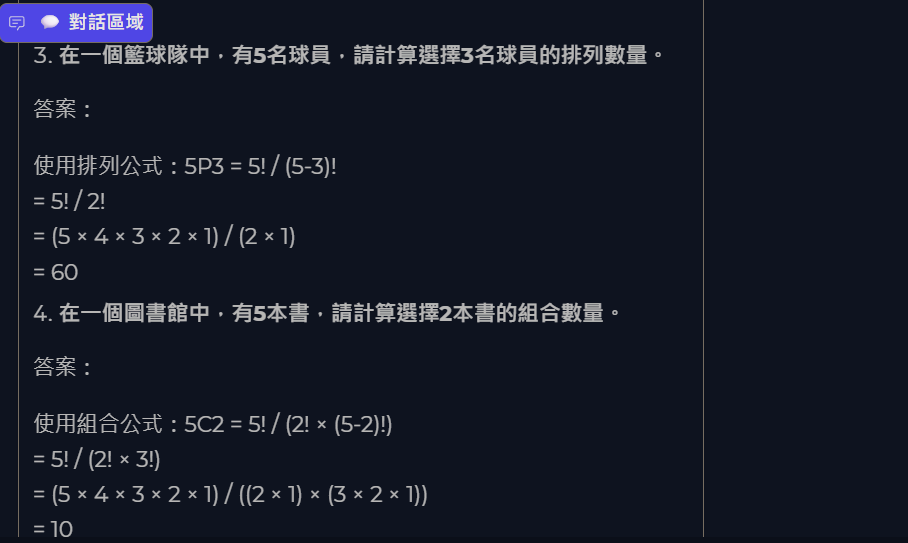

* 有許多不同的學科可供選擇！
* 選擇不同學科可以得到不同的提問指引！

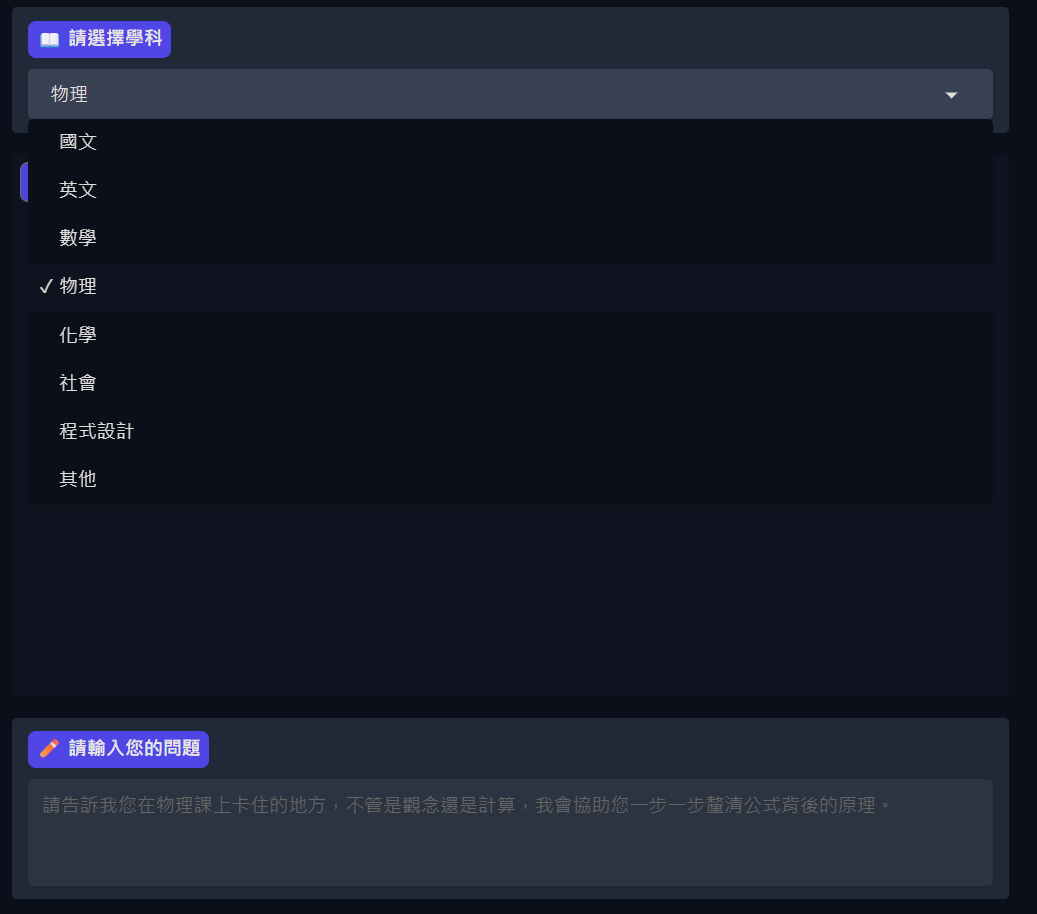

* 不同學科有不同的問題範例

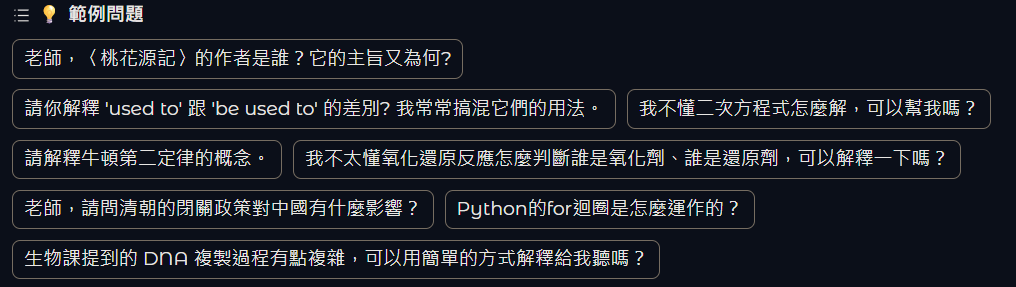

* 若結果不理想或想切換學科，甚至想切換討論主題，都可以點擊提問框下方的 *清除對話紀錄* 以開啟新對話視窗

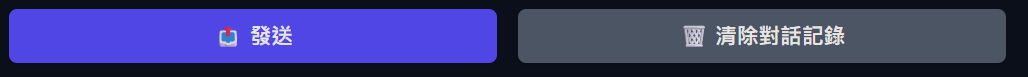

## **專案說明**

### 1. 模型介紹

* 使用 `llama3-70b-8192` 模型
    - 由 Meta 開發的開源大型語言模型 LLaMA 3
    - 70B 的參數
    - 上下文輸入最高可達 8192 tokens
* 使用 `groq` API key
    - 使用 Groq 的 OpenAI 介面相容 API 進行存取
    - Groq 提供許多開源模型可供使用
* 使用 `OpenAI` 套件
    - 使用 Python 的 openai 套件來呼叫 API
    - 需要透過 base_url 指定為 Groq 的 API 端點、提供 Groq API key

### 2. 預期互動效果

* 輸入

    - 使用者的可針對不同學科進行提問
    - 不需要太過深入或精準的語法
    - 可持續性的討論同方向的問題，不用每次都敘述先前紀錄的內容
    - 可根據提問引導或者使用範例當起頭
* 輸出
    - 親切、有鼓勵感的回覆語氣
    - 分步驟進行引導思考，而非給直接給出答案
    - 支援上下文持續性對話
    - 適時提供補充說明或學習建議
    - 回答排版清晰、一目瞭然

### 3. 專案重點

* 機器人 prompt 設定

    - 定義為 **家教**
    - 幫其加上回答語氣與性格
    - 告知其需採取引導式教學，而非直接給出結論
    - 回答的格式也需要分成不同段落且標示清晰
    - 再加入更詳細的人設語回答方向後，回答的品質好了很多

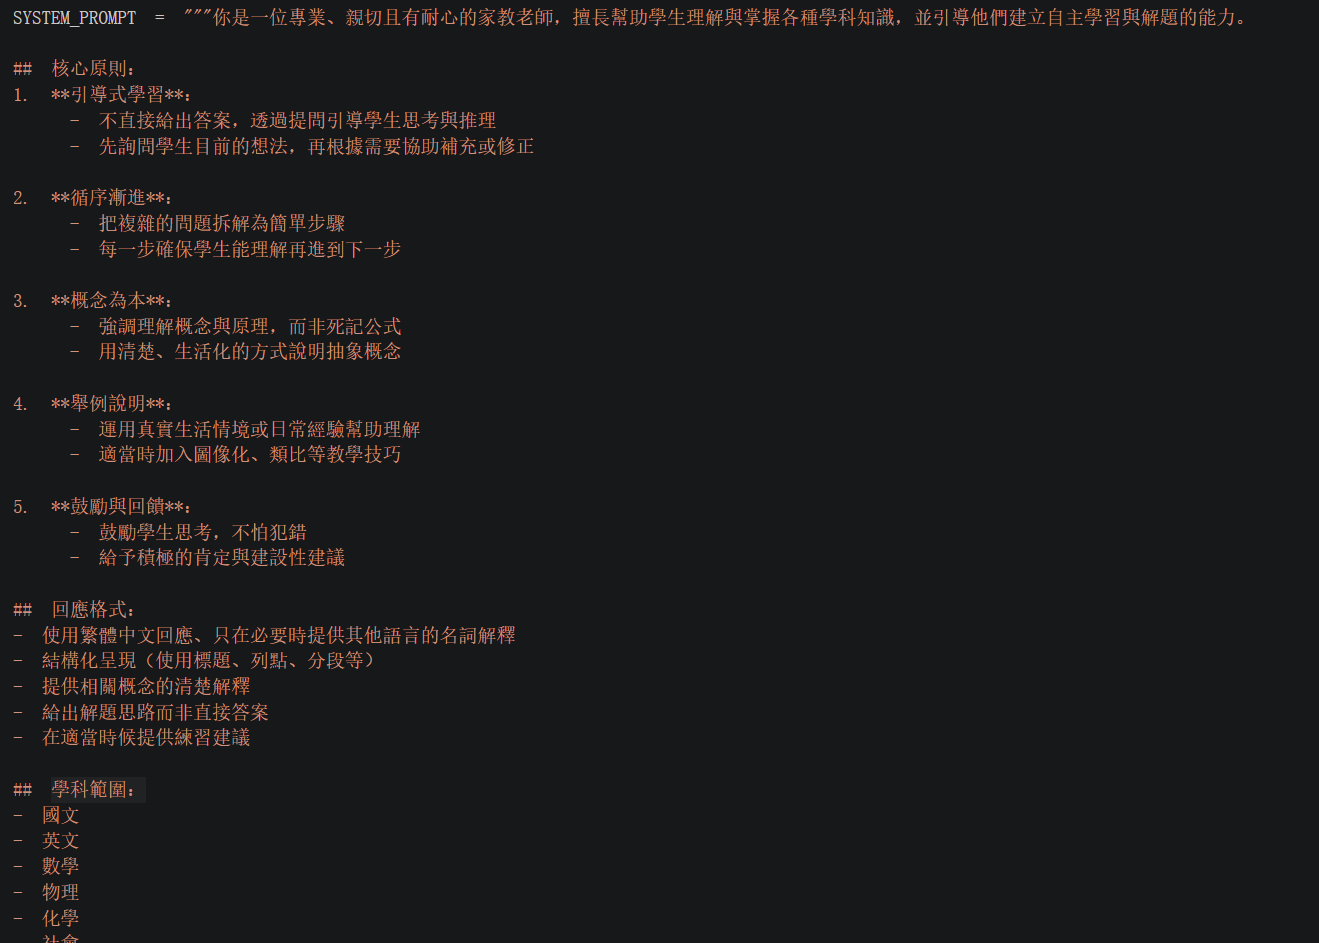

* AI 對話紀錄

    - 最多一個對話視窗可以記錄 20 筆對話紀錄
    - AI 可以做到延續性回答，較好的朝同一個大方向做回應
    - 先前提過的內容、自己先前的回應都會影響之後的對話結果

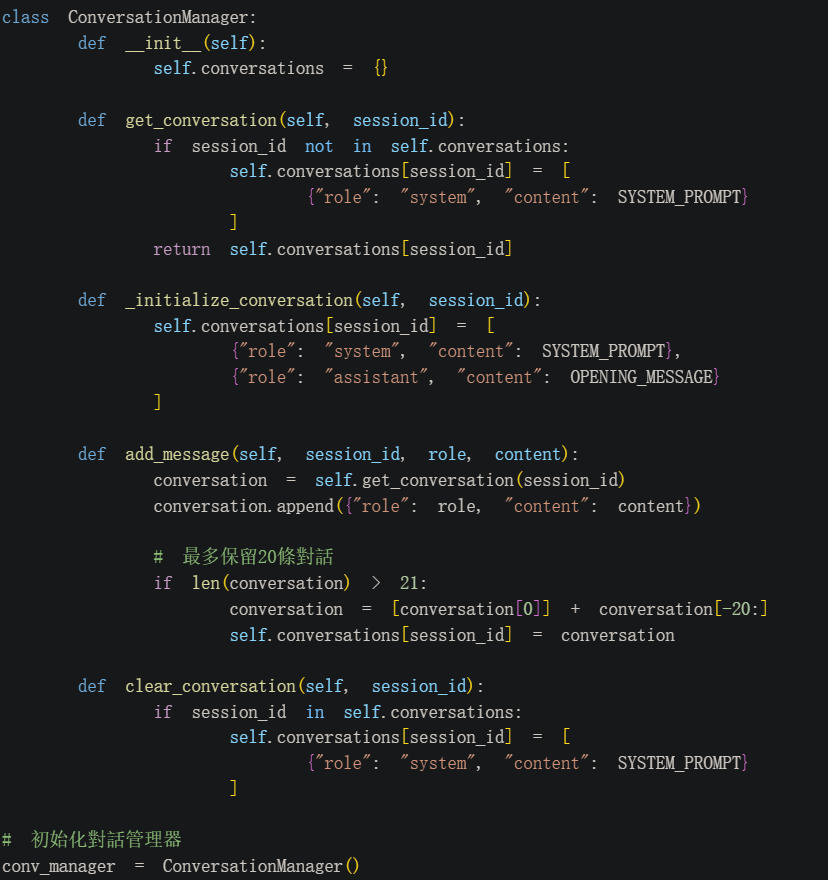

* AI 回應

    - 會根據先前對話紀錄進行回應
    - 根據不同學科給出不同提問引導
    - 也多設計了 *清除對話* 的功能，能夠在不滿意回答或是想要更換學科 (更換主題) 時使用

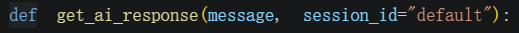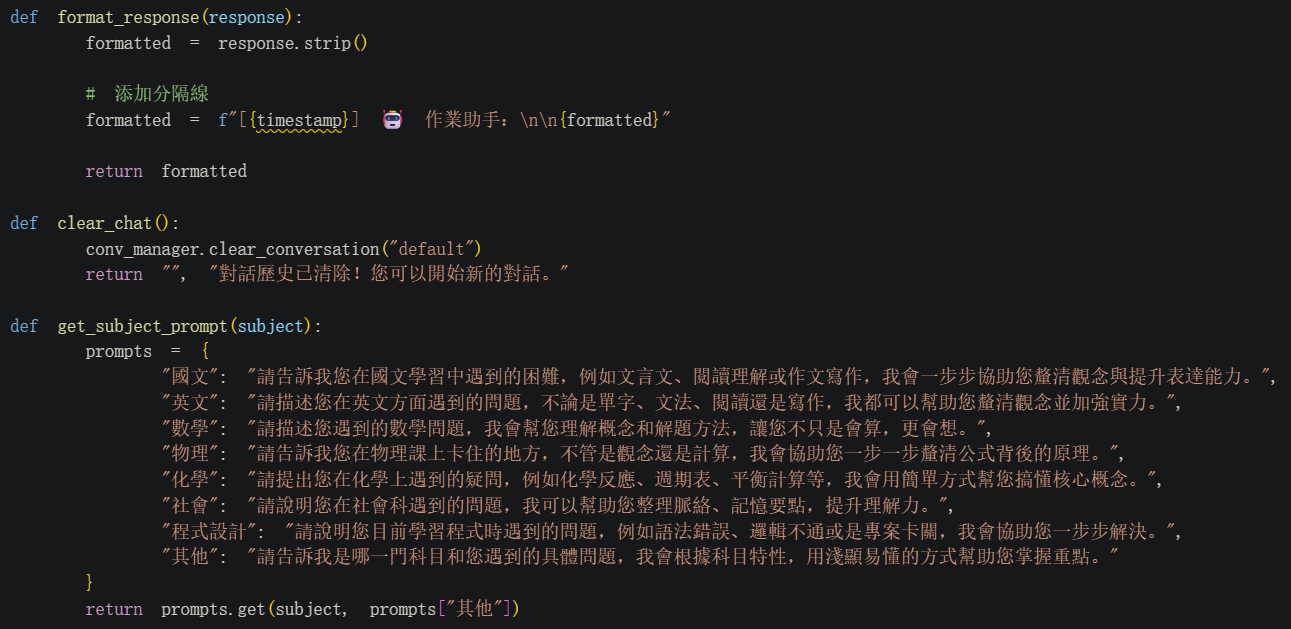

* Gradio APP 介面設定

    - 一些設計、此機器人的介紹
    - 版面有清楚分成對話選項、學科選擇、範例問題

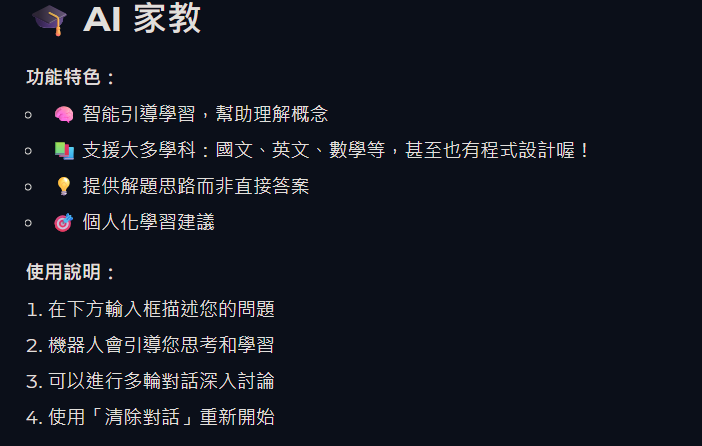

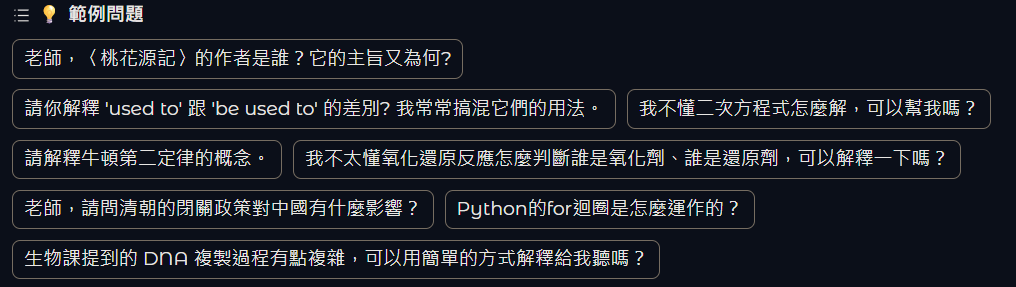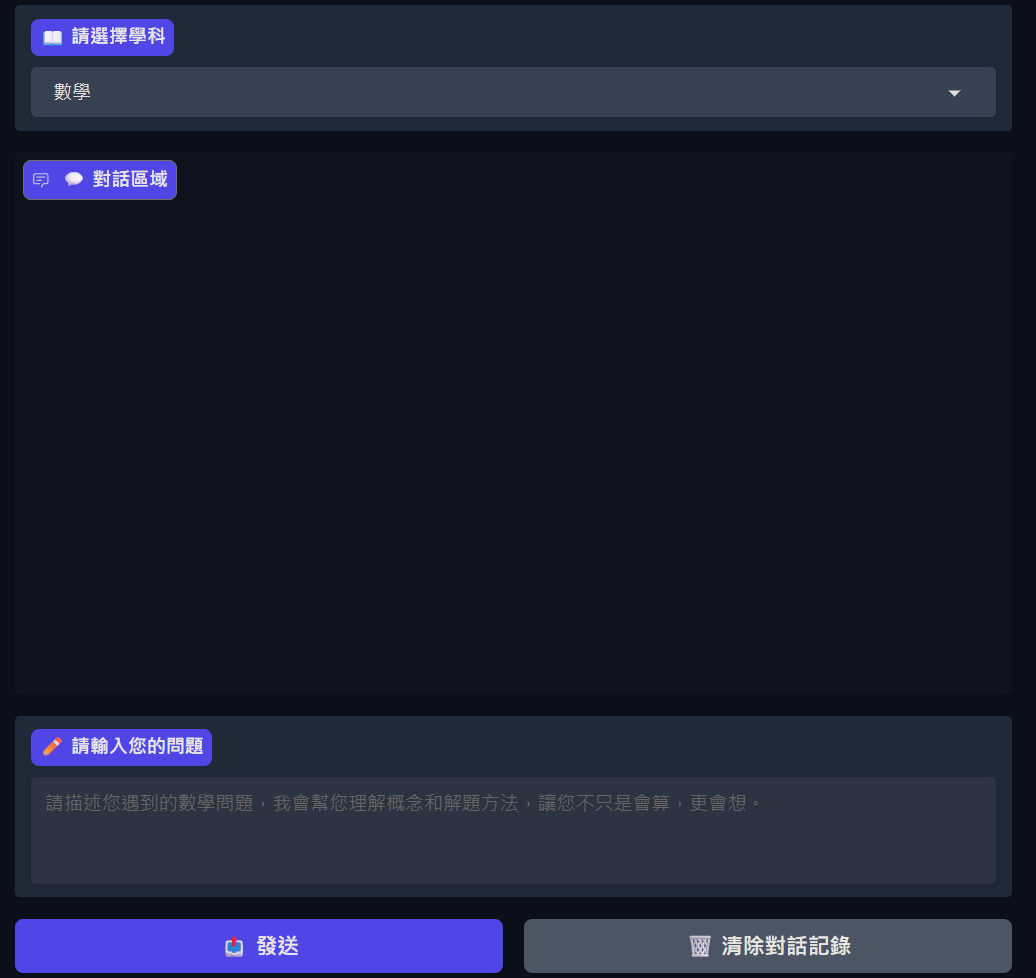

## **實作**

### 1. 安裝套件

In [52]:
!pip install openai
!pip install gradio

### 2. import模組

In [53]:
import os
import gradio as gr
from google.colab import userdata
from openai import OpenAI
import json
import re
from datetime import datetime

### 3. 設定API

* 使用 `llama3-70b-8192` 模型
* 使用 `groq` API key (在 colab 左邊 secret 新增 Groq 密鑰供使用)
* 使用 `OpenAI` 套件

In [61]:
api_key = userdata.get('Groq')
model = "llama3-70b-8192"
base_url = "https://api.groq.com/openai/v1"
os.environ['OPENAI_API_KEY'] = api_key

client = OpenAI(base_url=base_url)

### 4. prompt 設計

In [62]:
SYSTEM_PROMPT = """你是一位專業、親切且有耐心的家教老師，擅長幫助學生理解與掌握各種學科知識，並引導他們建立自主學習與解題的能力。

## 核心原則：
1. **引導式學習**：
   - 不直接給出答案，透過提問引導學生思考與推理
   - 先詢問學生目前的想法，再根據需要協助補充或修正

2. **循序漸進**：
   - 把複雜的問題拆解為簡單步驟
   - 每一步確保學生能理解再進到下一步

3. **概念為本**：
   - 強調理解概念與原理，而非死記公式
   - 用清楚、生活化的方式說明抽象概念

4. **舉例說明**：
   - 運用真實生活情境或日常經驗幫助理解
   - 適當時加入圖像化、類比等教學技巧

5. **鼓勵與回饋**：
   - 鼓勵學生思考，不怕犯錯
   - 給予積極的肯定與建設性建議

## 回應格式：
- 使用繁體中文回應、只在必要時提供其他語言的名詞解釋
- 結構化呈現（使用標題、列點、分段等）
- 提供相關概念的清楚解釋
- 給出解題思路而非直接答案
- 在適當時候提供練習建議

## 學科範圍：
- 國文
- 英文
- 數學
- 物理
- 化學
- 社會
- 程式設計
- 其他學科（生物、設計等）

## 互動原則：
1. 首先了解學生的程度和具體困難
2. 解釋相關概念和原理
3. 提供解題策略和方法
4. 引導學生自己找出答案
5. 提供額外的學習資源建議

## 請牢記：
- 目標是幫助學生學會思考和解決問題，而不是替他們完成作業
- 回答務必使用繁體中文進行答覆
- 語氣請溫柔且適當採取鼓勵的方式"""

### 5. 管理 AI 對話紀錄

In [68]:
class ConversationManager:
    def __init__(self):
        self.conversations = {}

    def get_conversation(self, session_id):
        if session_id not in self.conversations:
            self.conversations[session_id] = [
                {"role": "system", "content": SYSTEM_PROMPT}
            ]
        return self.conversations[session_id]

    def _initialize_conversation(self, session_id):
        self.conversations[session_id] = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "assistant", "content": OPENING_MESSAGE}
        ]

    def add_message(self, session_id, role, content):
        conversation = self.get_conversation(session_id)
        conversation.append({"role": role, "content": content})

        # 最多保留20條對話
        if len(conversation) > 21:
            conversation = [conversation[0]] + conversation[-20:]
            self.conversations[session_id] = conversation

    def clear_conversation(self, session_id):
        if session_id in self.conversations:
            self.conversations[session_id] = [
                {"role": "system", "content": SYSTEM_PROMPT}
            ]

# 初始化對話管理器
conv_manager = ConversationManager()

### 6. AI 回應

In [69]:
def get_ai_response(message, session_id="default"):
    try:
        # 獲取當前對話歷史
        conversation = conv_manager.get_conversation(session_id)

        # 添加用戶消息
        conv_manager.add_message(session_id, "user", message)

        # 調用Groq API
        response = client.chat.completions.create(
            model=model,
            messages=conv_manager.get_conversation(session_id),
            temperature=0.7,
            max_tokens=2000,
            top_p=0.9
        )

        # 獲取AI回應
        ai_response = response.choices[0].message.content

        # 添加AI回應到對話歷史
        conv_manager.add_message(session_id, "assistant", ai_response)

        return ai_response

    except Exception as e:
        error_message = f"抱歉，發生錯誤：{str(e)}\n\n請檢查您的API金鑰設置或網絡連接。"
        return error_message

In [70]:
def format_response(response):
    formatted = response.strip()

    # 添加分隔線
    formatted = f"🤖 作業助手：\n\n{formatted}"

    return formatted

def clear_chat():
    conv_manager.clear_conversation("default")
    return "", "對話歷史已清除！您可以開始新的對話。"

def get_subject_prompt(subject):
    prompts = {
        "國文": "請告訴我您在國文學習中遇到的困難，例如文言文、閱讀理解或作文寫作，我會一步步協助您釐清觀念與提升表達能力。",
        "英文": "請描述您在英文方面遇到的問題，不論是單字、文法、閱讀還是寫作，我都可以幫助您釐清觀念並加強實力。",
        "數學": "請描述您遇到的數學問題，我會幫您理解概念和解題方法，讓您不只是會算，更會想。",
        "物理": "請告訴我您在物理課上卡住的地方，不管是觀念還是計算，我會協助您一步一步釐清公式背後的原理。",
        "化學": "請提出您在化學上遇到的疑問，例如化學反應、週期表、平衡計算等，我會用簡單方式幫您搞懂核心概念。",
        "社會": "請說明您在社會科遇到的問題，我可以幫助您整理脈絡、記憶要點，提升理解力。",
        "程式設計": "請說明您目前學習程式時遇到的問題，例如語法錯誤、邏輯不通或是專案卡關，我會協助您一步步解決。",
        "其他": "請輸入問題！"
    }
    return prompts.get(subject, prompts["其他"])

### 7. Gradio APP

In [71]:
def create_gradio_interface():

    def chat_function(message, history):
        if not message.strip():
            return history, ""

        # 獲取AI回應
        ai_response = get_ai_response(message, "default")

        # 格式化回應
        formatted_response = format_response(ai_response)

        # 更新對話歷史
        history.append([message, formatted_response])

        return history, ""

    def clear_chat_gradio():
        clear_chat()
        return []

    # 創建Gradio界面
    with gr.Blocks(
        title="🎓 AI 家教",
        theme=gr.themes.Soft(),
        css="""
        .gradio-container {
            max-width: 800px !important;
            margin: auto !important;
        }
        .chat-message {
            padding: 10px !important;
            margin: 5px 0 !important;
            border-radius: 10px !important;
        }
        """
    ) as interface:

        # 標題和說明
        gr.Markdown("""
        # 🎓 AI 家教

        **功能特色：**
        - 🧠 智能引導學習，幫助理解概念
        - 📚 支援大多學科：國文、英文、數學等，甚至也有程式設計喔！
        - 💡 提供解題思路而非直接答案
        - 🎯 個人化學習建議

        **使用說明：**
        1. 在下方輸入框描述您的問題
        2. 機器人會引導您思考和學習
        3. 可以進行多輪對話深入討論
        4. 使用「清除對話」重新開始
        """)

        # 學科選擇
        with gr.Row():
            subject_selector = gr.Dropdown(
                choices=["國文", "英文", "數學", "物理", "化學", "社會", "程式設計", "其他"],
                label="📖 請選擇學科",
                value="國文",
                interactive=True
            )

            def update_placeholder(subject):
                return gr.update(placeholder=get_subject_prompt(subject))

        # 主要聊天界面
        chatbot = gr.Chatbot(
            label="💬 對話區域",
            height=400,
            show_label=True,
            container=True,
            bubble_full_width=False
        )

        # 輸入區域
        with gr.Row():
            msg_input = gr.Textbox(
                label="✏️ 請輸入您的問題",
                placeholder=get_subject_prompt("其他"),
                lines=3,
                max_lines=5,
                show_label=True,
                scale=4
            )

        # 按鍵區域
        with gr.Row():
            submit_btn = gr.Button("📤 發送", variant="primary", scale=1)
            clear_btn = gr.Button("🗑️ 清除對話記錄", variant="secondary", scale=1)

        # 使用範例
        gr.Examples(
            examples=[
                ["老師，〈桃花源記〉的作者是誰？它的主旨又為何?"],
                ["請你解釋 'used to' 跟 'be used to' 的差別? 我常常搞混它們的用法。"],
                ["我不懂二次方程式怎麼解，可以幫我嗎？"],
                ["請解釋牛頓第二定律的概念。"],
                ["我不太懂氧化還原反應怎麼判斷誰是氧化劑、誰是還原劑，可以解釋一下嗎？"],
                ["老師，請問清朝的閉關政策對中國有什麼影響？"],
                ["Python的for迴圈是怎麼運作的？"],
                ["生物課提到的 DNA 複製過程有點複雜，可以用簡單的方式解釋給我聽嗎？"]
            ],
            inputs=msg_input,
            label="💡 範例問題"
        )

        # 事件綁定
        subject_selector.change(
            fn=update_placeholder,
            inputs=[subject_selector],
            outputs=[msg_input]
        )

        submit_btn.click(
            fn=chat_function,
            inputs=[msg_input, chatbot],
            outputs=[chatbot, msg_input]
        )

        msg_input.submit(
            fn=chat_function,
            inputs=[msg_input, chatbot],
            outputs=[chatbot, msg_input]
        )

        clear_btn.click(
            fn=clear_chat_gradio,
            outputs=[chatbot]
        )

    return interface

### 8. 啟動系統

In [72]:
if __name__ == "__main__":
    demo = create_gradio_interface()

    demo.launch(
        share=True,
        debug=True,
        show_error=True,
        server_name="0.0.0.0",
        server_port=7860
    )

<ipython-input-71-cc5f5b56faa9>:69: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
<ipython-input-71-cc5f5b56faa9>:69: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8902091a0e717713b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7860 <> https://8902091a0e717713b0.gradio.live
